## Import Needed Libs

In [33]:
import numpy as np
import codecs
import tensorflow as tf
import pandas as pd
import ast
import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
# import seaborn as sns
import pandas as pd
import re
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import re
import warnings
warnings.filterwarnings('ignore')

import the data

In [34]:
data = pd.read_csv('first_aid.csv')

In [35]:
data.head(10)

,tag,patterns,responses,context_set
0,Cuts,"['What to do if Cuts?', 'How to cure Cuts?', '...",['Wash the cut properly to prevent infection a...,NaN
1,Abrasions,"['how do you treat abrasions?', 'Do Abrasions ...",['Begin with washed hands.Gently clean the are...,NaN
2,stings,"['How do you treat Sting?', 'Stings', 'What to...",['Remove any stingers immediately. Some expert...,NaN
3,Splinter,"['How to remove Splinters', 'How to cure Splin...",['1. SOAK IT IN EPSOM SALTS. Dissolve a cup of...,NaN
4,Sprains,"['How do you treat a sprain?', 'what to do if ...","[""Use an ice pack or ice slush bath immediatel...",NaN
5,Strains,"['How do you treat a strain?', 'what to do if ...","['Rest,Ice,Compression and Elevation can be us...",NaN
6,Fever,"['How do you treat a mild Fever?', 'what to do...",['To treat a fever at home: 1)Drink plenty of ...,NaN
7,Nasal Congestion,"['How do you treat nasal Congestion?', 'what t...","['When you’re stuffed up, focus on keeping you...",NaN
8,Cough,"['How to cure cough?', 'How do you treat cough...","['1) Honey:- Use honey to treat a cough, mix 2...",NaN
9,Sore Throat,"['How do you treat sore throat?', 'what to do ...",['1) Make sure you get plenty of rest and drin...,NaN


In [36]:
print(data.shape)

(44, 4)


## Extract useful data

In this step, we need to get only useful information for the project.

Main concern is (Description and Doctor) pair columns only

In [37]:
data_df = data[['patterns', 'responses']]
data_df.head()

,patterns,responses
0,"['What to do if Cuts?', 'How to cure Cuts?', '...",['Wash the cut properly to prevent infection a...
1,"['how do you treat abrasions?', 'Do Abrasions ...",['Begin with washed hands.Gently clean the are...
2,"['How do you treat Sting?', 'Stings', 'What to...",['Remove any stingers immediately. Some expert...
3,"['How to remove Splinters', 'How to cure Splin...",['1. SOAK IT IN EPSOM SALTS. Dissolve a cup of...
4,"['How do you treat a sprain?', 'what to do if ...","[""Use an ice pack or ice slush bath immediatel..."


### then, extract useful words

In [38]:
total_strings = data_df['patterns'].values.tolist() + data['responses'].values.tolist()
all_strings = " ".join(total_strings)
pattern = re.compile(r"[\w]*'[\w]*")
matchings = re.findall(pattern, all_strings)

In [39]:
# show the extracted words
set(matchings)

{"'",
 "'1",
 "'Abrasions",
 "'Begin",
 "'Cuts",
 "'Do",
 "'Give",
 "'How",
 "'Is",
 "'Remove",
 "'Rest",
 "'Stings",
 "'To",
 "'Wash",
 "'What",
 "'When",
 "'Which",
 "'While",
 "'cure",
 "'fever",
 "'flush",
 "'how",
 "'i",
 "'what",
 "Don't",
 "Splinters'",
 "doesn't",
 "dog'",
 "isn't",
 "it's",
 "person's",
 "snake'",
 "that's",
 "what's",
 "worsen'",
 "you're",
 "you've"}

### Data Preprocessing

Removing special characters and doing decontraction

In [40]:
def decontractions(phrase):
    #specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"won\’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = re.sub(r"n\’t", " not", phrase)
    phrase = re.sub(r"\’re", " are", phrase)
    phrase = re.sub(r"\’s", " is", phrase)
    phrase = re.sub(r"\’d", " would", phrase)
    phrase = re.sub(r"\’ll", " will", phrase)
    phrase = re.sub(r"\’t", " not", phrase)
    phrase = re.sub(r"\’ve", " have", phrase)
    phrase = re.sub(r"\’m", " am", phrase)

    return phrase

def preprocess(text):
    text = text.lower()
    text = decontractions(text)
    text = re.sub('[^A-Za-z0-9 ]+', '', text)
    return text


data_df['patterns'] = data_df['patterns'].apply(preprocess)
data_df['responses'] = data_df['responses'].apply(preprocess)
data.head()

,tag,patterns,responses,context_set
0,Cuts,"['What to do if Cuts?', 'How to cure Cuts?', '...",['Wash the cut properly to prevent infection a...,NaN
1,Abrasions,"['how do you treat abrasions?', 'Do Abrasions ...",['Begin with washed hands.Gently clean the are...,NaN
2,stings,"['How do you treat Sting?', 'Stings', 'What to...",['Remove any stingers immediately. Some expert...,NaN
3,Splinter,"['How to remove Splinters', 'How to cure Splin...",['1. SOAK IT IN EPSOM SALTS. Dissolve a cup of...,NaN
4,Sprains,"['How do you treat a sprain?', 'what to do if ...","[""Use an ice pack or ice slush bath immediatel...",NaN


In [41]:
q_lengths = data_df['patterns'].str.split().apply(len)
a_lengths = data_df['responses'].str.split().apply(len)

In [42]:
from tqdm import tqdm
all_ques = " ".join(data_df['patterns'].values)
all_ans = " ".join(data_df['responses'].values)
word_cnt_a = {}
for i in tqdm(all_ans.split()): word_cnt_a[i] = word_cnt_a.get(i, 0) + 1
word_cnt_q = {}
for i in tqdm(all_ques.split()): word_cnt_q[i] = word_cnt_q.get(i, 0) + 1

100%|██████████| 1300/1300 [00:00<00:00, 1186120.34it/s]


In [43]:
word_ordered_a = sorted(word_cnt_a, key=lambda x: word_cnt_a[x], reverse=True)
top_20_a = word_ordered_a[:20]
cnts_20_a = [word_cnt_a[i] for i in top_20_a]

word_ordered_q = sorted(word_cnt_q, key=lambda x: word_cnt_q[x], reverse=True)
top_20_q = word_ordered_q[:20]
cnts_20_q = [word_cnt_q[i] for i in top_20_q]

In [44]:
import seaborn as sns

sns.set(rc={'figure.figsize':(11.7,8.27)})
def plot(top_words, counts):
    fig, ax = plt.subplots()

    # Save the chart so we can loop through the bars below.
    bars = ax.bar(
        x=np.arange(len(top_words)),
        height=counts,
        tick_label=top_words
    )

    # Axis formatting.
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_color('#DDDDDD')
    ax.tick_params(bottom=False, left=False)
    ax.set_axisbelow(True)
    ax.yaxis.grid(True, color='#EEEEEE')
    ax.xaxis.grid(False)

    # Add text annotations to the top of the bars.
    bar_color = bars[0].get_facecolor()
    for bar in bars:
      ax.text(
          bar.get_x() + bar.get_width() / 2,
          bar.get_height() + 0.3,
          round(bar.get_height(), 1),
          horizontalalignment='center',
          color=bar_color,
          weight='bold'
      )

    # Add labels and a title. Note the use of `labelpad` and `pad` to add some
    # extra space between the text and the tick labels.
    ax.set_xlabel('Word', labelpad=15, color='#333333')
    ax.set_ylabel('Count', labelpad=15, color='#333333')
    ax.set_title("Most usual words in reply/answers", pad=15, color='#333333',
                 weight='bold')

    fig.tight_layout()

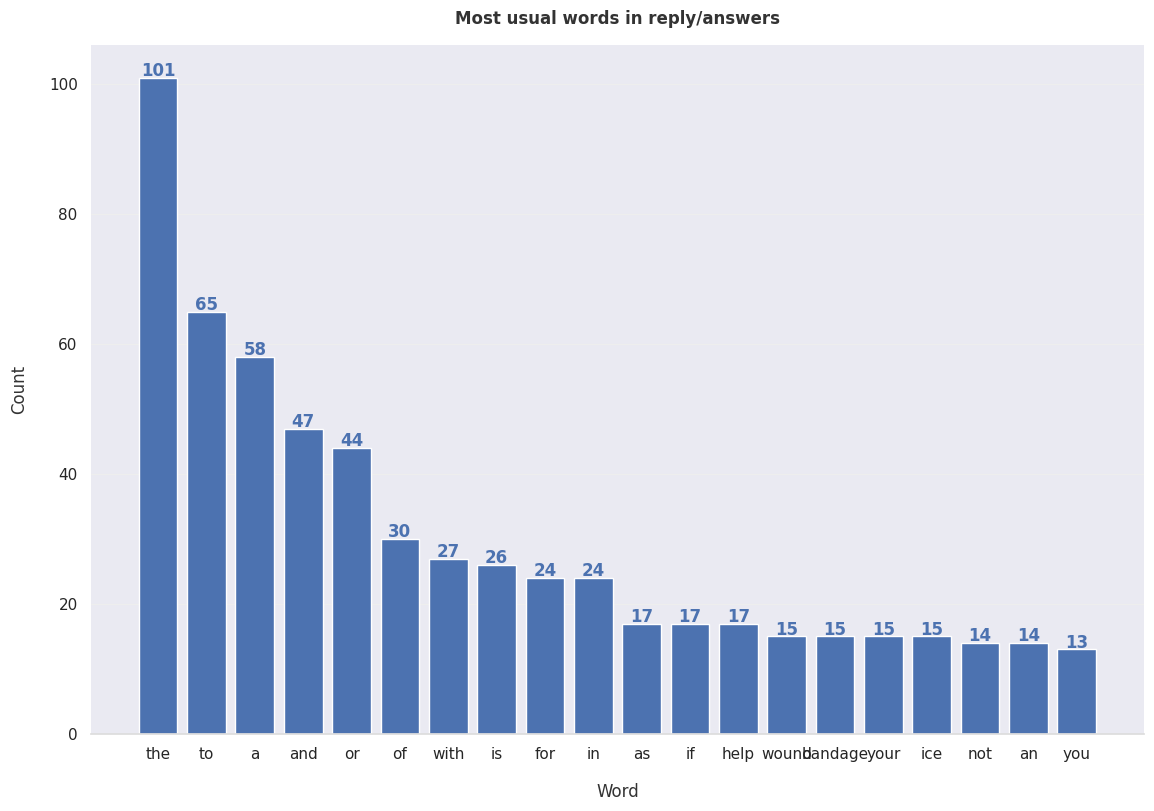

In [45]:
plot(top_20_a, cnts_20_a)

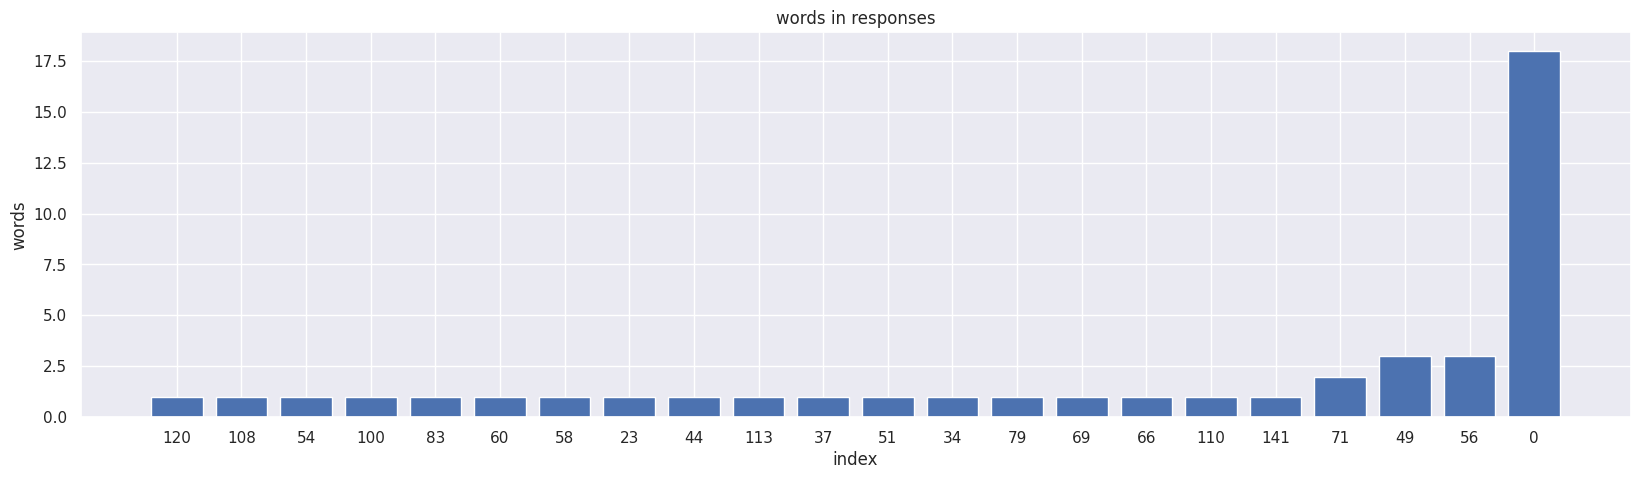

In [46]:
answer_count = data_df['responses'].str.split().apply(len).value_counts()
word_dict = dict(answer_count)
word_dict = dict(sorted(word_dict.items(), key=lambda kv: kv[1]))
ind = np.arange(len(word_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(word_dict.values()))

plt.ylabel('words')
plt.xlabel('index')
plt.title('words in responses')
plt.xticks(ind, list(word_dict.keys()))
plt.show()

In [47]:
# Minimum no. of words required
for i in range(0,101,10):
    print(i,np.percentile(q_lengths, i))
print("="*80)
for i in range(90,101):
    print(i,np.percentile(q_lengths, i))
print("="*80)
for i in [99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]:
    print(i,np.percentile(q_lengths, i))

0 20.0
10 25.0
20 25.6
30 26.0
40 28.0
50 29.0
60 30.0
70 30.0
80 31.4
90 32.0
100 51.0
90 32.0
91 32.65000000000001
92 34.80000000000001
93 36.95000000000001
94 41.199999999999946
95 45.500000000000014
96 47.0
97 47.0
98 47.56
99 49.28
100 51.0
99.1 49.452
99.2 49.623999999999995
99.3 49.79599999999999
99.4 49.96800000000002
99.5 50.139999999999986
99.6 50.31200000000001
99.7 50.48400000000001
99.8 50.656000000000006
99.9 50.82800000000003
100 51.0


## encoder decoder
Adding <start>, <end> tokens, for to apply one time-shifted technique!


In [48]:
data_df['answer_in'] = '<start> ' + data_df['responses'].astype(str)
data_df['answer_out'] = data_df['responses'].astype(str) + ' <end>'
data_df.head()

,patterns,responses,answer_in,answer_out
0,what to do if cuts how to cure cuts which medi...,wash the cut properly to prevent infection and...,<start> wash the cut properly to prevent infec...,wash the cut properly to prevent infection and...
1,how do you treat abrasions wouldo abrasions c...,begin with washed handsgently clean the area w...,<start> begin with washed handsgently clean th...,begin with washed handsgently clean the area w...
2,how do you treat sting istings what to do if ...,aremove any stingers immediately some experts...,<start> aremove any stingers immediately some...,aremove any stingers immediately some experts...
3,how to remove splinters how to cure splinters ...,1 soak it in epsom salts dissolve a cup of the...,<start> 1 soak it in epsom salts dissolve a cu...,1 soak it in epsom salts dissolve a cup of the...
4,how do you treat a sprain what to do if i get ...,use an ice pack or ice slush bath immediately ...,<start> use an ice pack or ice slush bath imme...,use an ice pack or ice slush bath immediately ...


In [49]:
data_final = data_df.drop(['responses'], axis=1)
data_final.head()

,patterns,answer_in,answer_out
0,what to do if cuts how to cure cuts which medi...,<start> wash the cut properly to prevent infec...,wash the cut properly to prevent infection and...
1,how do you treat abrasions wouldo abrasions c...,<start> begin with washed handsgently clean th...,begin with washed handsgently clean the area w...
2,how do you treat sting istings what to do if ...,<start> aremove any stingers immediately some...,aremove any stingers immediately some experts...
3,how to remove splinters how to cure splinters ...,<start> 1 soak it in epsom salts dissolve a cu...,1 soak it in epsom salts dissolve a cup of the...
4,how do you treat a sprain what to do if i get ...,<start> use an ice pack or ice slush bath imme...,use an ice pack or ice slush bath immediately ...


In [50]:
from sklearn.model_selection import train_test_split
train, validation = train_test_split(data_final, test_size=0.3)

In [51]:
train.iloc[0]['answer_in']= str(train.iloc[0]['answer_in'])+' <end>'
train.iloc[0]['answer_out']= str(train.iloc[0]['answer_out'])+' <end>'

In [52]:
data_df.head()

,patterns,responses,answer_in,answer_out
0,what to do if cuts how to cure cuts which medi...,wash the cut properly to prevent infection and...,<start> wash the cut properly to prevent infec...,wash the cut properly to prevent infection and...
1,how do you treat abrasions wouldo abrasions c...,begin with washed handsgently clean the area w...,<start> begin with washed handsgently clean th...,begin with washed handsgently clean the area w...
2,how do you treat sting istings what to do if ...,aremove any stingers immediately some experts...,<start> aremove any stingers immediately some...,aremove any stingers immediately some experts...
3,how to remove splinters how to cure splinters ...,1 soak it in epsom salts dissolve a cup of the...,<start> 1 soak it in epsom salts dissolve a cu...,1 soak it in epsom salts dissolve a cup of the...
4,how do you treat a sprain what to do if i get ...,use an ice pack or ice slush bath immediately ...,<start> use an ice pack or ice slush bath imme...,use an ice pack or ice slush bath immediately ...


In [53]:
# drop the answer_in and answer_out
train = train.drop(['answer_in', 'answer_out'], axis=1)
validation = validation.drop(['answer_in', 'answer_out'], axis=1)

In [54]:
# save the new train and validation data
train.to_csv('train.csv', index=False)
validation.to_csv('validation.csv', index=False)


data.head()

,tag,patterns,responses,context_set
0,Cuts,"['What to do if Cuts?', 'How to cure Cuts?', '...",['Wash the cut properly to prevent infection a...,NaN
1,Abrasions,"['how do you treat abrasions?', 'Do Abrasions ...",['Begin with washed hands.Gently clean the are...,NaN
2,stings,"['How do you treat Sting?', 'Stings', 'What to...",['Remove any stingers immediately. Some expert...,NaN
3,Splinter,"['How to remove Splinters', 'How to cure Splin...",['1. SOAK IT IN EPSOM SALTS. Dissolve a cup of...,NaN
4,Sprains,"['How do you treat a sprain?', 'what to do if ...","[""Use an ice pack or ice slush bath immediatel...",NaN


In [55]:
# save the data to processed folder
data_processed = data.drop(['context_set'], axis=1)
data_processed.to_csv('processed_data.csv', index=False)